# Introduction to Crunchers

In this notebook we demonstrate crunchers, silicone's most fundamental infilling methods. You will need to install silicone from as described in the readme in order to run this code. It introduces one specific cruncher, the 'closest RMS' cruncher, and the basic tools to manipulate it. Other crunchers will be documented in other notebooks. 

## Imports

In [1]:
import os.path
import traceback

import pandas as pd
import pyam
import matplotlib.pyplot as plt
import numpy as np

import silicone.database_crunchers
from silicone.utils import (
    _get_unit_of_variable,
    find_matching_scenarios,
    _make_interpolator,
    _make_wide_db, 
    get_sr15_scenarios
)
import silicone.scripts

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


## Assembling example data

Here we pull some example data by downloading it from the IAMC 1.5°C Scenario Explorer and Data hosted by IIASA (for details, see Huppman et al 2019, Integrated Assessment Modeling Consortium & International Institute for Applied Systems Analysis, 2018). If the data has already been downloaded before, we will use that instead for brevity. We select only a few cases

In [2]:
valid_model_ids = [
        "MESSAGE*",
        "AIM*",
        "C-ROADS*",
        "GCAM*",
        #"IEA*",
        #"IMAGE*",
        #"MERGE*",
        #"POLES*",
        #"REMIND*",
        "WITCH*"
    ]
SR15_SCENARIOS = "./sr15_scenarios.csv"
if not os.path.isfile(SR15_SCENARIOS):
    get_sr15_scenarios(SR15_SCENARIOS, valid_model_ids)

### Starting point

Our starting point is the test data, loaded as a `pyam.IamDataFrame`. It may be helpful for understanding some of this tutorial for you to know more about IamDataFrames, documented at https://pyam-iamc.readthedocs.io/en/latest/. The key functions are `.filter()`, which selects a subset of data, and `.timeseries()`, which restructures the data into columns by date, with long indexes containing information other than the value. 

In [3]:
sr15_data = pyam.IamDataFrame(SR15_SCENARIOS)
sr15_data.timeseries().head()

pyam.utils - INFO: Reading `./sr15_scenarios.csv`


2000  \
model       scenario               region variable                                           unit      subannual meta         
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0.0       0      NaN   
                                          Emissions|CH4                                      Mt CH4/yr 0.0       0      NaN   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr 0.0       0      NaN   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr 0.0       0      NaN   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr 0.0       0      NaN   

                                                                                                                           2005  \
model       scenario               region variable                                           unit      subannual meta             
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0.0       0       8.3367   
                                          Emissions|CH4                                      Mt CH4/yr 0.0       0     344.9167   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr 0.0       0     167.6717   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr 0.0       0       0.4732   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr 0.0       0      11.2639   

                                                                                                                           2010  \
model       scenario               region variable                                           unit      subannual meta             
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0.0       0       7.6408   
                                          Emissions|CH4                                      Mt CH4/yr 0.0       0     367.7457   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr 0.0       0     179.6356   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr 0.0       0       0.5168   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr 0.0       0      11.1249   

                                                                                                                       2014  \
model       scenario               region variable                                           unit      subannual meta         
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0.0       0      NaN   
                                          Emissions|CH4                                      Mt CH4/yr 0.0       0      NaN   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr 0.0       0      NaN   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr 0.0       0      NaN   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr 0.0       0      NaN   

                                                                                                                           2015  \
model       scenario               region variable                                           unit      subannual meta             
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0.0       0       7.2724   
                                          Emissions|CH4                                      Mt CH4/yr 0.0    

## Crunchers

Silicone's 'crunchers' are used to determine the relationship between a 'follower variable' and 'lead variable(s)' from a given database. The 'follower variable' is the variable for which we want to generate data e.g. `Emissions|C3F8` while the 'lead variable(s)' is the variable we want to use in order to infer a timeseries of the 'follower variable'. The lead variable is currently always a list with only a single item, e.g. `[Emissions|HFC]` but in future may be able to deal with several elements. The follower is always a single string - to infill multiple values in a collective way (e.g. splitting HFC into its various components) see Multiple Infillers. 

Each cruncher needs to be initialised with a database and has a `derive_relationship` method, which returns the infilling function. Its docstring describes what it does.

In [4]:
print(silicone.database_crunchers.base._DatabaseCruncher.derive_relationship.__doc__)
# # an alternative, pop-up interface is shown if you uncomment the line below
#silicone.database_crunchers.base._DatabaseCruncher.derive_relationship?


        Derive the relationship between two variables from the database

        Parameters
        ----------
        variable_follower : str
            The variable for which we want to calculate timeseries (e.g.
            ``"Emissions|C5F12"``).

        variable_leaders : list[str]
            The variables we want to use in order to infer timeseries of
            ``variable_follower`` (e.g. ``["Emissions|CO2", "Emissions|CH4"]``)

        **kwargs
            Keyword arguments used by this class to derive the relationship between
            ``variable_follower`` and ``variable_leaders``.

        Returns
        -------
        :obj:`func`
            Function which takes a :obj:`pyam.IamDataFrame` containing
            ``variable_leaders`` timeseries and returns timeseries for
            ``variable_follower`` based on the derived relationship between the two.
            Please see the source code for the exact definition (and docstring) of the
            returned functi

These crunchers are best explored by looking at the examples below.

### Closest Root Mean Square cruncher

This cruncher finds the scenario and model in the infiller database that minimises the RMS distance between the the lead emissions in the infiller and infillee data. The follow data is then directly taken from that scenario. 
The full documentation is as follows:

In [5]:
print(silicone.database_crunchers.DatabaseCruncherRMSClosest.__doc__)


    Database cruncher which uses the 'closest RMS' technkque.

    This cruncher derives the relationship between two variables by finding the
    scenario which has the closest lead gas timeseries in the database.  The follower
    gas timeseries is then simply copied from the closest scenario.

    Here, 'closest' is defined as the smallest time-averaged root mean squared (L2)
    difference.

    .. math::
        RMS = \left ( \frac{1}{n} \sum_{t=0}^n (E_l(t) - E_l^{d}(t))^2 \right )^{1/2}

    where :math:`n` is the total number of timesteps in the lead gas' timeseries,
    :math:`E_l(t)` is the lead gas emissions timeseries and :math:`E_l^d(t)` is a lead
    gas emissions timeseries in the database.
    


#### Infilling

Firstly, let's cut the database down to a size that is comprehensible.

In [2]:
sr15_data_closest_rms = sr15_data.filter(model=["WITCH-GLOBIOM 4.2"])
sr15_data_closest_rms.head()

NameError: name 'sr15_data' is not defined

Next, we initialise the type of cruncher we want with the infiller database. 

In [7]:
cruncher = silicone.database_crunchers.DatabaseCruncherRMSClosest(sr15_data_closest_rms)

Now we can derive the relationship between the follower and leader, here `Emissions|CO2` and `Emissions|VOC` respectively. This returns a infiller function, which we will use later. Firstly we will check out the docstring. 

In [8]:
filler = cruncher.derive_relationship("Emissions|VOC", ["Emissions|CO2"])
print(filler.__doc__)
# filler info:


            Filler function derived from :obj:`DatabaseCruncherRMSClosest`.

            Parameters
            ----------
            in_iamdf : :obj:`pyam.IamDataFrame`
                Input data to fill data in

            Returns
            -------
            :obj:`pyam.IamDataFrame`
                Filled in data (without original source data)

            Raises
            ------
            ValueError
                If there are any inconsistencies between the timeseries, units or
                expectations of the program and ``in_iamdf``, compared to the database
                used to generate this ``filler`` function.
            


Now we can use this relationship to do some infilling. As a sanity check, we firstly make sure that if we pass in a CO$_2$ timeseries which is already in the database, we get back its VOC emissions timeseries. 

In [9]:
example_model_scen = {
    "model": "WITCH-GLOBIOM 4.2",
    "scenario": "ADVANCE_INDC",
}
example_input = sr15_data_closest_rms.filter(**example_model_scen).data
example_input["model"] = "example"
example_input["scenario"] = "example"
example_input = pyam.IamDataFrame(example_input)

We can now use the function we returned above to infill the example data, and see that we recover the data we put in. 

In [10]:
example_input_filled = filler(example_input)
example_input_filled.timeseries()

,,,,,,,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
model,scenario,region,variable,unit,subannual,meta,,,,,,,,,,,,,,,,,,,,
example,example,World,Emissions|VOC,Mt VOC/yr,0.0,0,189.212,164.056724,153.575866,145.611005,130.387433,115.465871,102.038923,89.302542,76.60488,62.855685,58.440154,56.971497,55.075327,53.101911,51.074418,49.558506,47.602518,45.377459,43.08547,41.400122


In [11]:
sr15_data_closest_rms.filter(variable="Emissions|VOC", **example_model_scen).timeseries()

,,,,,,,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
model,scenario,region,variable,unit,subannual,meta,,,,,,,,,,,,,,,,,,,,
WITCH-GLOBIOM 4.2,ADVANCE_INDC,World,Emissions|VOC,Mt VOC/yr,0.0,0,189.212,164.056724,153.575866,145.611005,130.387433,115.465871,102.038923,89.302542,76.60488,62.855685,58.440154,56.971497,55.075327,53.101911,51.074418,49.558506,47.602518,45.377459,43.08547,41.400122


As expected, the cruncher has picked out the scenario which matches and returned its VOC timeseries. This can also be seen in a plot below, where the dashed (infilled) line perfectly matches the pink line. 

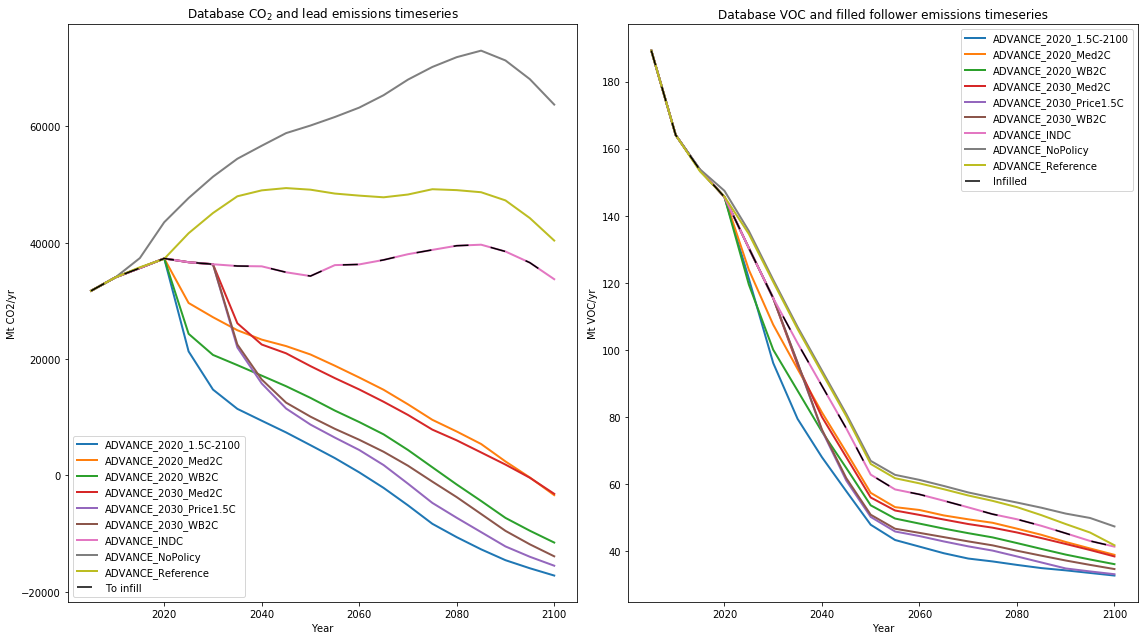

In [12]:
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_closest_rms.filter(variable="*CO2").line_plot(ax=ax, **pkwargs)
example_input.filter(variable="*CO2").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15), label="To infill")
ax.set_title("Database CO$_2$ and lead emissions timeseries")

ax = fig.add_subplot(122)
sr15_data_closest_rms.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
example_input_filled.filter(variable="*VOC").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15), label="Infilled")
ax.set_title("Database VOC and filled follower emissions timeseries")

plt.tight_layout()

Now we can use our filler to infill other timeseries not present in our infiller database.

In [13]:
filler_input = sr15_data.filter(model="MESSAGEix-GLOBIOM 1.0", scenario="CD-LINKS_NPi2020_1600")
# This scenario is missing `Emissions|VOC`. 
filler_input.filter(variable="Emissions|VOC").data

pyam.core - WARNING: Filtered IamDataFrame is empty!


,model,scenario,region,variable,unit,year,subannual,meta,value


In [14]:
# It can go in the same infiller we defined previously.
filler_input_filled = filler(filler_input)

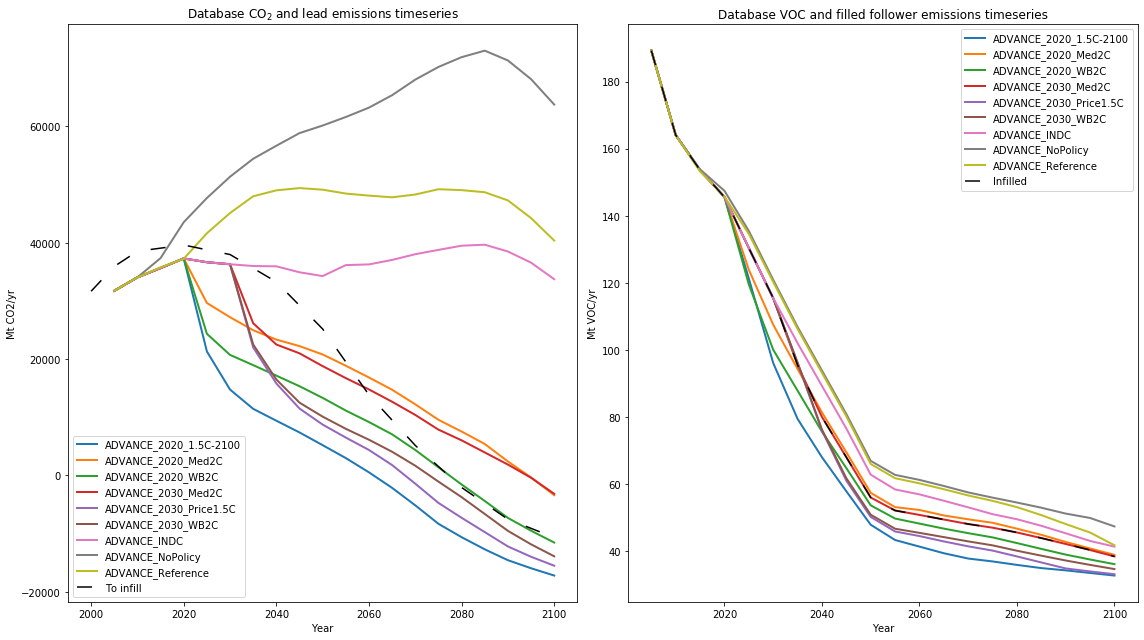

In [15]:
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_closest_rms.filter(variable="*CO2").line_plot(ax=ax, **pkwargs)
filler_input.filter(variable="*CO2").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15), label="To infill")
ax.set_title("Database CO$_2$ and lead emissions timeseries")

ax = fig.add_subplot(122)
sr15_data_closest_rms.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
filler_input_filled.filter(variable="*VOC").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15), label="Infilled")
ax.set_title("Database VOC and filled follower emissions timeseries")

plt.tight_layout()

As we can see, on an RMS basis our input timeseries is closest to the 'ADVANCE_2030_Med2C' scenario and hence its `Emissions|VOC` pathway is returned.

In [16]:
filler_input_filled.timeseries()

,,,,,,,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
model,scenario,region,variable,unit,subannual,meta,,,,,,,,,,,,,,,,,,,,
MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,0.0,0,189.212,164.056724,153.575866,145.611005,130.387433,115.465871,95.506957,80.043895,68.04429,56.038428,52.164286,50.849028,49.479184,48.134296,47.046133,45.615107,43.948576,42.192038,40.390822,38.480263


In [17]:
sr15_data_closest_rms.filter(scenario="ADVANCE_2030_Med2C", variable="Emissions|VOC").timeseries()

,,,,,,,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
model,scenario,region,variable,unit,subannual,meta,,,,,,,,,,,,,,,,,,,,
WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,0.0,0,189.212,164.056724,153.575866,145.611005,130.387433,115.465871,95.506957,80.043895,68.04429,56.038428,52.164286,50.849028,49.479184,48.134296,47.046133,45.615107,43.948576,42.192038,40.390822,38.480263


This may be regarded as conceptually the simplest of the data-based crunchers. The other crunchers are introduced in other notebooks. 